![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )

Smallest sphere enclosing a set of points.
===========================

The aim of this tutorial is two-fold

1. Demostrate how to write a conic quadratic model in `Fusion` in a very simple and compact way.
2. Show how and way the dual formulation may solved more efficiently.


Our problem is the defined as:

**Find the smallest sphere that encloses a set of** $k$ **points** $p_i \in \mathbb{R}^n$. 

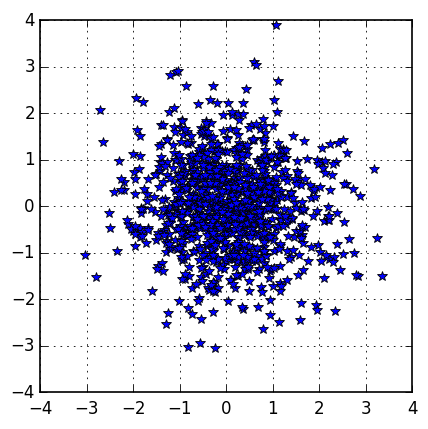

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

def plot_points(p, p0=[], r0=0.):
    n,k= len(p0), len(p)
    
    plt.rc('savefig',dpi=120)

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([ p[i][0] for i in range(k)], [ p[i][1] for i in range(k)], 'b*')
    
    if len(p0)>0:
        ax.plot(  p0[0], p0[1], 'r.')
        ax.add_patch( mpatches.Circle( p0,  r0 ,  fc="w", ec="r", lw=1.5) )
    plt.grid()
    plt.show()

n = 2
k = 1000

p=  [ [random.gauss(0.,1.) for nn in range(n)] for kk in range(k)]

plot_points(p)

The problem boils down to determine the sphere center $p_0\in \mathbb{R}^n$ and its radius $r_0\geq 0$, i.e.


\begin{equation}
  \begin{aligned}
\min \max_{i=1,\dots,k} \| p_0 - p_i\|_2 \\
  \end{aligned}
\end{equation}

The maximum in the objective function can be easily, i.e.

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& r_i \geq \| p_0 - p_i\|_2 ,& \quad & i=1,\ldots,k\\
\end{aligned}
\end{equation}

The SOCP formulation reads

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& (r_0,p_0 - p_i) \in Q^{(n+1)}, & \quad & i=1,\ldots,k.
\end{aligned}
\end{equation}

Before defining the constraints, we note that we can write


\begin{equation}
R_0 = \left( \begin{array}{c} r_0   \\ \vdots \\ r_0   \end{array} \right) \in \mathbb{R}^k          , \quad
P_0 = \left( \begin{array}{c} p_0^T \\ \vdots \\ p_0^T \end{array} \right) \in \mathbb{R}^{k\times n}, \quad
P   = \left( \begin{array}{c} p_1^T \\ \vdots \\ p_k^T \end{array} \right) \in \mathbb{R}^{k\times n}.
\end{equation}

so that 

\begin{equation}
(r_0,p_i - p_0) \in Q^{(n+1)},  \quad  i=1,\ldots,k.
\end{equation}

can be compactly expressed as 

\begin{equation}
(R_0,P_0-P) \in \Pi Q^{(n+1)}.
\end{equation}

Now we are ready for a compact implementation in `Fusion`:

In [69]:
from mosek.fusion import *

def primal_problem(P):
    
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - primal") as M:

        r0 = M.variable(1         , Domain.greaterThan(0.))
        p0 = M.variable(NDSet(1,n), Domain.unbounded())

        R0 = Variable.repeat(r0,k)
        P0 = Variable.repeat(p0,k)
        M.constraint( Expr.hstack( R0, Expr.sub( P0 , DenseMatrix(P) ) ), Domain.inQCone())

        M.objective(ObjectiveSense.Minimize, r0)
        M.setLogHandler(open('logp','wt'))

        M.solve()

        return r0.level()[0], p0.level()
           

We will also store the solver output in a file to use it later on. And then just solve the problem.

In [70]:
r0,p0 = primal_problem(p)

print "r0^* = ", r0
print "p0^* = ", p0

r0^* =  3.61208480147
p0^* =  [0.26510108823706946, 0.3877528271002255]


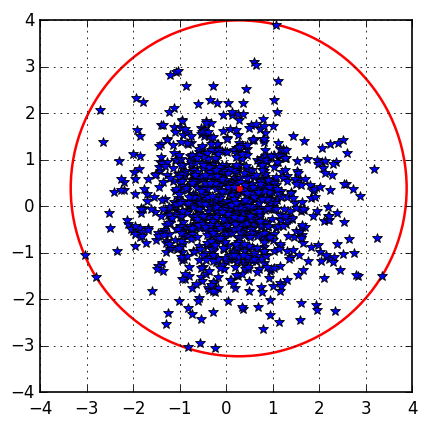

In [71]:
plot_points(p,p0,r0)

Dual Formulation 
-----------------------

The dual problem can be determined in few steps following basic rules. Introducing dual variables

\begin{equation}
 Y = \left( \begin{array}{c} y_1^T\\ \vdots \\y_k  \end{array}\right), \quad z = \left( \begin{array}{c} z_1\\ \vdots \\z_k  \end{array}\right), 
\end{equation}

the dual is:

\begin{aligned}
    \max & \left\langle P, Y \right\rangle \\
    & \sum_i z_i = 1\\
    & e^T Y = \mathbf{0}_n \\
    & (z_i , y_i) \in \mathcal{Q}^{n+1}\\
    & z_i\in \mathbb{R}, y_i\in \mathbb{R}^n,
\end{aligned}

where $e$ is a vector of all ones.

The ``Fusion`` code is the following:


In [72]:
def dual_problem(P):
        
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - dual") as M:
  
        Y= M.variable(NDSet(k,n), Domain.unbounded())
        z= M.variable(k,Domain.unbounded())
                    
        M.constraint(Expr.sum(z), Domain.equalsTo(1.) )
        
        e= [1.0 for i in range(k)]
        M.constraint(Expr.mul(e,Y), Domain.equalsTo(0.) )

        M.constraint( Expr.hstack(z,Y), Domain.inQCone())
        
        M.objective( ObjectiveSense.Maximize, Expr.dot( DenseMatrix(P), Y )) 
  
        M.setLogHandler(open('logd','wt'))

        M.solve()

    
dual_problem(p)

Let's take a closer look to the solver output:

In [73]:
!tail  log*

==> logd <==
11  2.1e-03  4.1e-06  2.1e-06  1.00e+00   3.612637601e+00   3.612465612e+00   2.1e-06  0.05  
12  4.3e-04  8.4e-07  4.3e-07  1.00e+00   3.612154270e+00   3.612120306e+00   4.3e-07  0.05  
13  5.9e-05  1.2e-07  5.9e-08  1.00e+00   3.612089856e+00   3.612086503e+00   5.9e-08  0.05  
14  1.1e-05  2.1e-08  1.1e-08  1.00e+00   3.612085452e+00   3.612084883e+00   1.1e-08  0.06  
15  9.1e-07  1.8e-09  2.7e-09  1.00e+00   3.612084792e+00   3.612084756e+00   9.1e-10  0.06  
16  3.5e-08  1.1e-10  3.5e-08  1.00e+00   3.612084627e+00   3.612084749e+00   5.5e-11  0.06  
17  3.5e-08  1.1e-10  3.5e-08  1.00e+00   3.612084627e+00   3.612084749e+00   5.5e-11  0.07  
Interior-point optimizer terminated. Time: 0.07. 

Optimizer terminated. Time: 0.07    

==> logp <==
9   1.7e-04  1.4e-04  2.9e-04  1.03e+00   3.625252444e+00   3.635456031e+00   1.4e-04  0.08  
10  7.4e-05  6.3e-05  1.3e-04  1.01e+00   3.619777686e+00   3.623558536e+00   6.3e-05  0.09  
11  5.3e-06  4.5e-06  9.0e-06  1.00e+00

In [74]:
%%bash
echo -------- Scalar Variables
grep Scalar log*
echo -------- Cones
grep Cones log*
echo -------- Constraints 
grep Constraints log*


-------- Scalar Variables
logd:  Scalar variables       : 6000            
logd:Optimizer  - Scalar variables       : 3000              conic                  : 3000            
logp:  Scalar variables       : 3003            
logp:Optimizer  - Scalar variables       : 3000              conic                  : 3000            
-------- Cones
logd:  Cones                  : 1000            
logd:Optimizer  - Cones                  : 1000
logp:  Cones                  : 1000            
logp:Optimizer  - Cones                  : 1000
-------- Constraints
logd:  Constraints            : 3003            
logd:Optimizer  - Constraints            : 3
logp:  Constraints            : 3000            
logp:Optimizer  - Constraints            : 2997


**Why is that?**

`Fusion` performs the following transformation:

\begin{equation}
Ax - b \in \mathcal{K} \rightarrow \quad \left\lbrace\begin{array}{ll} y = Ax-b\\ y\in \mathcal{K} \end{array}\right.
\end{equation}

The reason is to ensure that each variable belongs only in one cone.

**What is then the reason of the different running time?**

* **MOSEK** uses a primal-dual algorithm that solves both primal and dual at the same time,
* therefore internally there is no difference in terms of problem size.

**So why is the dual formulation so much faster?**

The answer comes from a closer inspection to the solver output, in particular the reported `flops`:


In [75]:
!grep flop log* 

logd:Factor     - dense dim.             : 0                 flops                  : 2.60e+04        
logp:Factor     - dense dim.             : 5                 flops                  : 1.94e+05        


In [76]:
!grep flop log* | cut -d':' -f 4 | xargs printf "1/(%f/%f)\n" | bc -l

7.46153846153846153889


In [77]:
!grep "Interior-point optimizer" log* | cut -d':' -f 3| cut -d'.' -f1-2  | xargs printf "1/(%f/%f)\n" | bc -l

1.71428571428571428572


When moving from theory to practical implementation, **MOSEK** is somehow biased towards the primal, i.e. the formulation we input:

* some steps, most notably factorizations, are in practice order dependent,
* it is important to not be mislead by the problem dimension looking only at the number of variables, constraints and cones,
* if performance are a concern, both primal and dual should be tried.

---------------------------------------------------------------------------------------------------------------

The **MOSEK** logo and name are trademarks of Mosek ApS.

The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed.

For more information contact [support_at_mosek.com](mailto:support@mosek.com)

---------------------------------------------------------------------------------------------------------------


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The MOSEK collection of iPython Notebook</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" property="cc:attributionName" rel="cc:attributionURL">MOSEK ApS</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/MOSEK" rel="dct:source">https://github.com/MOSEK</a>.<br />Permissions beyond the scope of this license may be available at <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" rel="cc:morePermissions">www.mosek.com</a>.

In [78]:
!cat logp

Computer
  Platform               : Linux/64-X86    
  Cores                  : 2               

Problem
  Name                   : minimal sphere enclosing a set of points - primal
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3000            
  Cones                  : 1000            
  Scalar variables       : 3003            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01   

In [79]:
!cat logd

Computer
  Platform               : Linux/64-X86    
  Cores                  : 2               

Problem
  Name                   : minimal sphere enclosing a set of points - dual
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3003            
  Cones                  : 1000            
  Scalar variables       : 6000            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
